In the previous file, we have learned that creating an index will speed up commonly executed queries. By default, an index creates a **b-tree structure** on a column, separate from the table, which allows filtered queries to execute more efficiently.

In this file, we will be expanding on the concept of indexing, and we will dive into Postgres' advanced indexing features. The features we will investigate are
* multiple column indexes, 
* different types of indexes, and 
* partial indexes. 

We can think of these concepts as adding options to an index.

But why are there so many features of an index? Wasn't one column index enough? Let's run through an example and see why we might want more than one index.

In the previous file we ran queries that filtered a single column. However, oftentimes, we want to constrain our queries by additional columns.

Imagine that we wanted to find all rows in `homeless_by_coc` with the `state` of **Florida** where the `year` is greater than **2010**, then we would write the following:

`SELECT * FROM homeless_by_coc 
WHERE state = 'FL' AND year > '2010-01-01';`

Let's create an single index on the `state` column and explain the query using the `EXPLAIN` command to see what kind of query plan we are facing.

Recall that to [create an index](https://www.postgresql.org/docs/12/sql-createindex.html) on a table, we run the following:

`CREATE INDEX index_name on table_name(column_name);`

**Task**

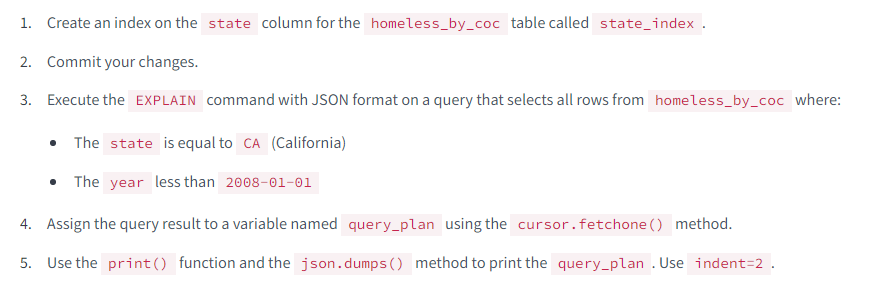

**Answer**

`import json
import psycopg2
conn = psycopg2.connect("dbname=hud user=hud_admin password=hud_pwd")
cur = conn.cursor()`

`cur.execute("CREATE INDEX state_index ON homeless_by_coc(state);")
conn.commit()`

`cur.execute("""
    EXPLAIN (FORMAT json) 
    SELECT state FROM homeless_by_coc 
    WHERE state = 'CA' AND year < '2008-01-01';
""")`

`query_plan = cur.fetchone()
print(json.dumps(query_plan[0], indent=2))`

Here's the output from the query plan from the above:

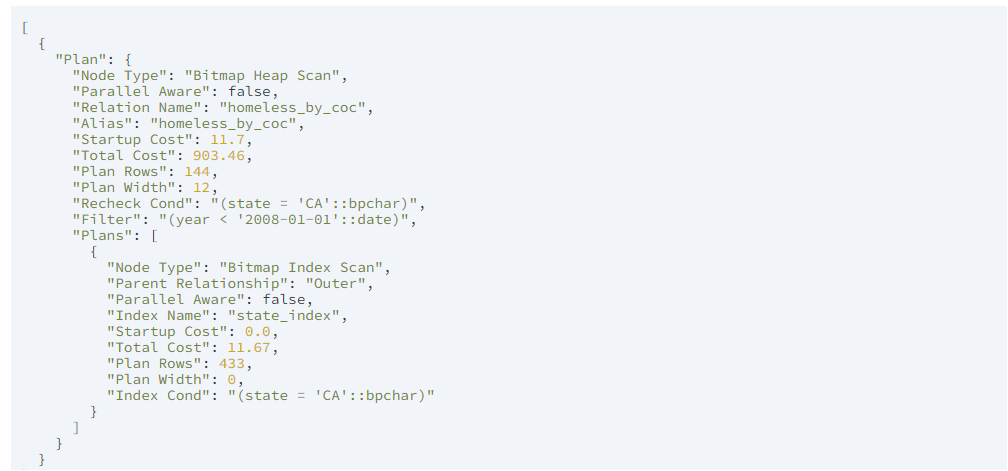

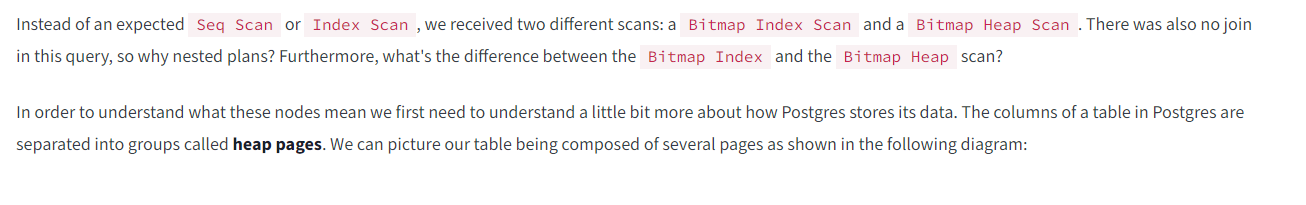

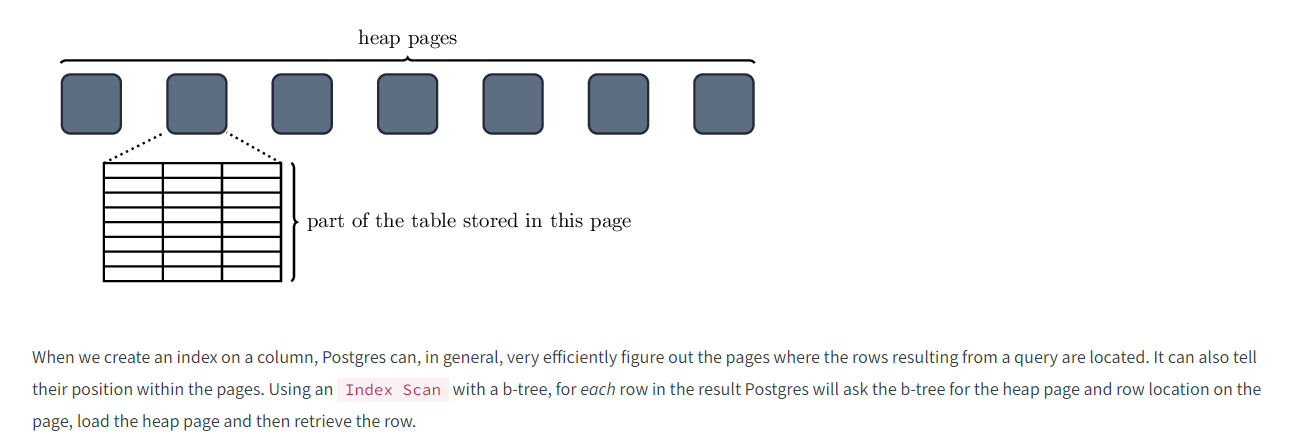

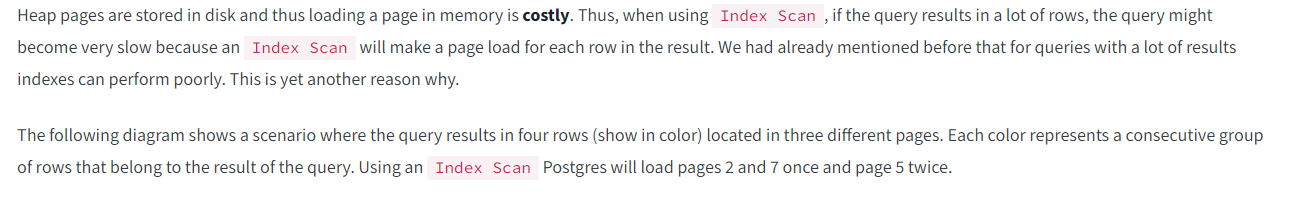

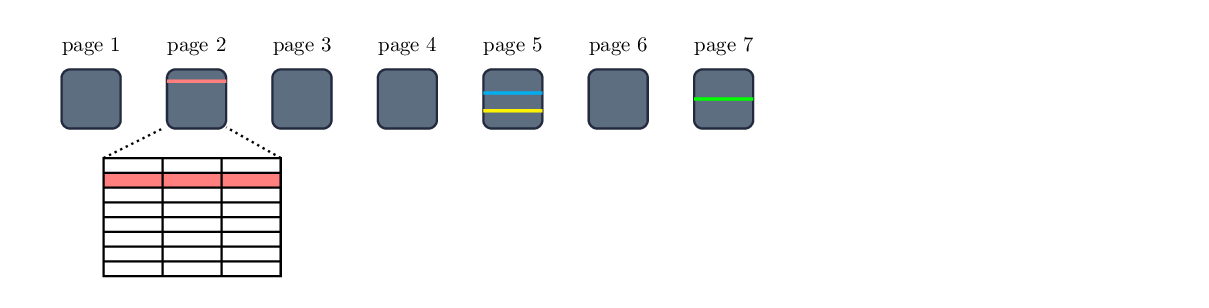

The query plan that we obtained from above shows an alternative strategy where first, Postgres uses the index to figure out the heap pages that contain results. Then it will read each of those pages entirely in order to fetch the results.

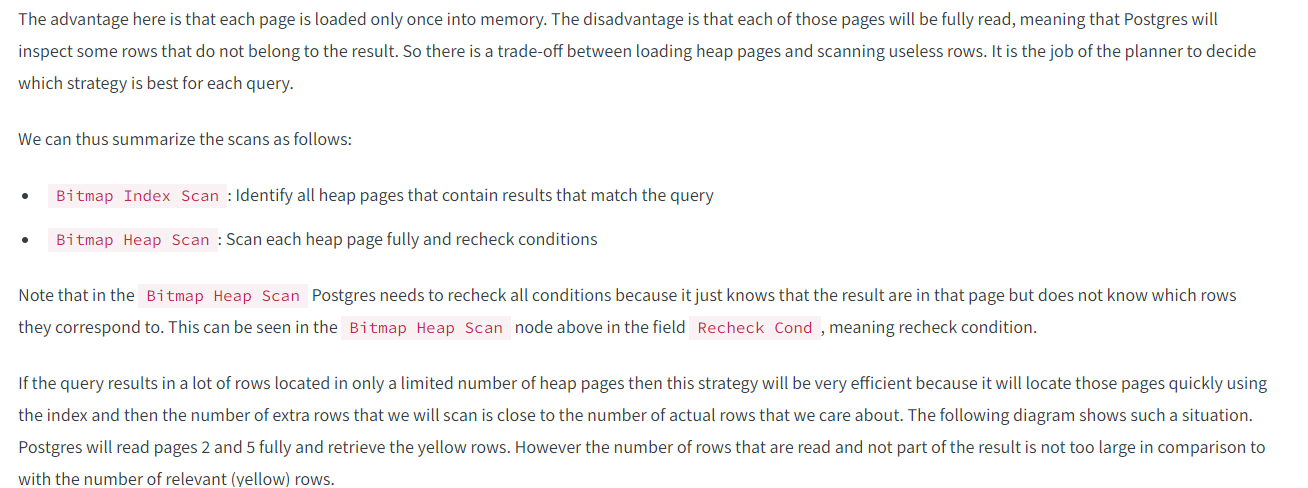

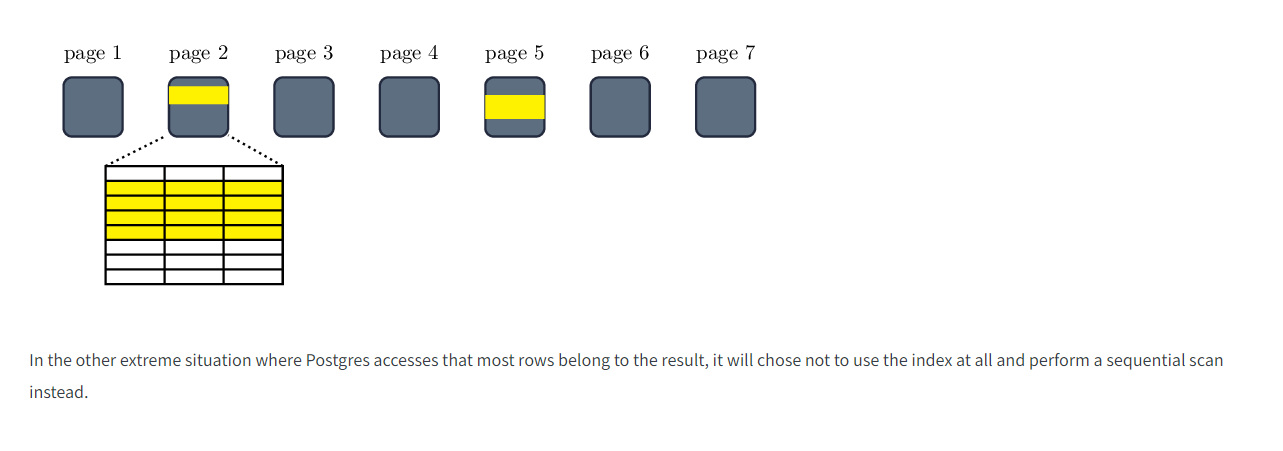

We can make the query run faster by creating a index that takes **both** columns into account. This type of index is called a **multi-column index**. If we commonly run queries that filters two specific columns, then using a multi-column index can speed up our query times.


To [create a multi-column index](https://www.postgresql.org/docs/12/sql-createindex.html), we run a command similar to creating single index. The only addition is placing the second column, within parentheses, separated by a comma from the first column. By convention, we name the index by the order of the columns.

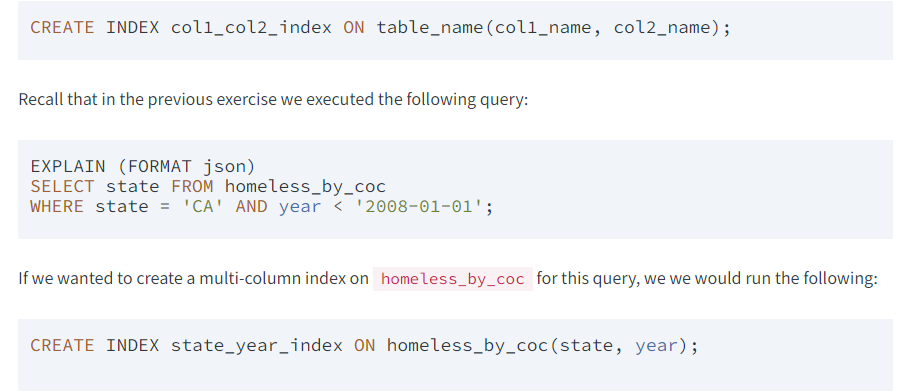

The reason for selecting the `state` and `year` columns is that those are the columns that are used in the `WHERE` statement. Before we delve into understand how multi-column indexes work internally, let's try it out to see the benefits.

Note that the **order** of the columns when we create and index is important. We will understand why later in this file.

**Task**

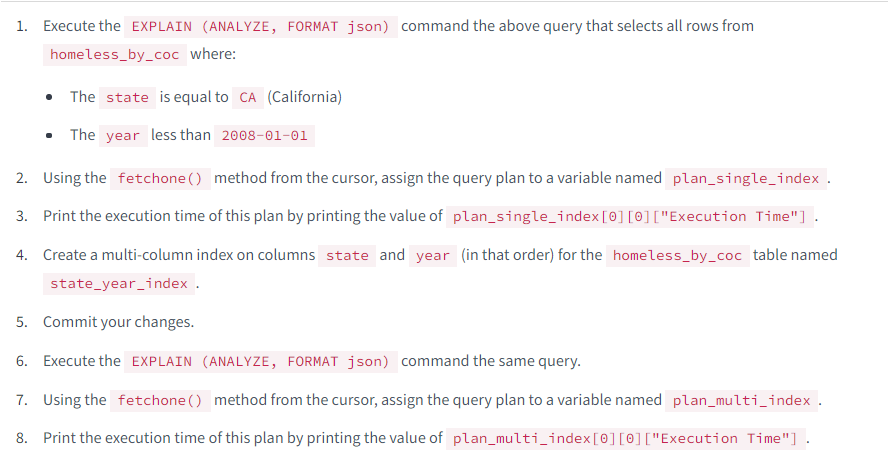

**Answer**

`import psycopg2
import json
conn = psycopg2.connect("dbname=hud user=hud_admin password=hud_pwd")
cur = conn.cursor()`

`cur.execute("""
    EXPLAIN (ANALYZE, FORMAT json) 
    SELECT * FROM homeless_by_coc 
    WHERE state='CA' AND year < '2008-01-01';
""")`

`plan_single_index = cur.fetchone()
print(plan_single_index[0][0]["Execution Time"])`

`cur.execute("CREATE INDEX state_year_index ON homeless_by_coc(state, year);")
conn.commit()`

`cur.execute("""
    EXPLAIN (ANALYZE, FORMAT json)
    SELECT * FROM homeless_by_coc
    WHERE state='CA' AND year < '2008-01-01';
""")`

`plan_multi_index = cur.fetchone()
print(plan_multi_index[0][0]["Execution Time"])`

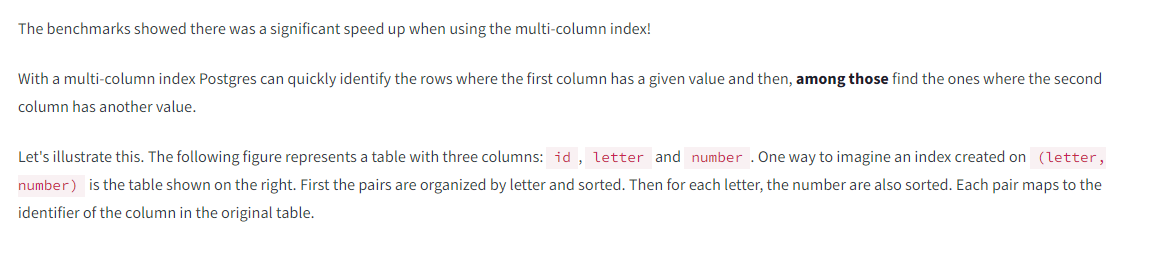

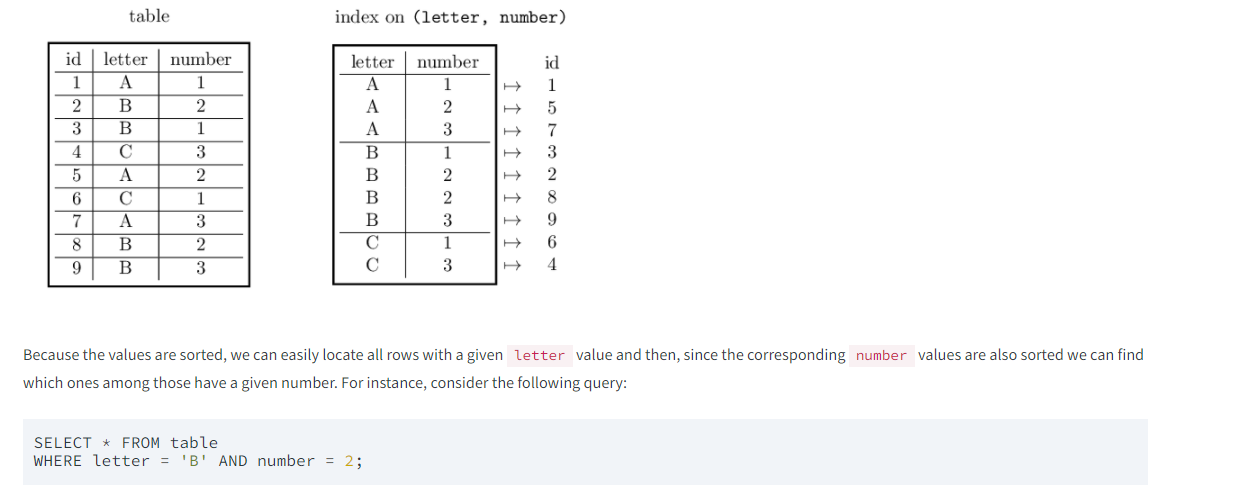

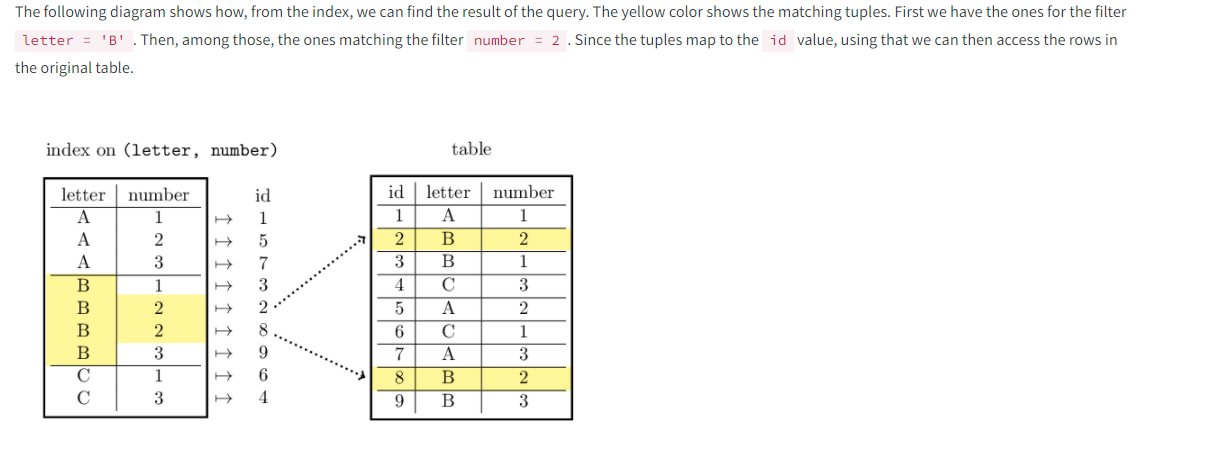

Imagine that we want to find page 100 of a book. We start by opening the book roughly in the middle. We read the page number and see it is 250. Then we know that we only need to search the left part of the book because, since page numbers are **sorted**, all pages on the right side have page number greater than or equal to 251. By repeating this process, we will quickly find the page that we are looking for.

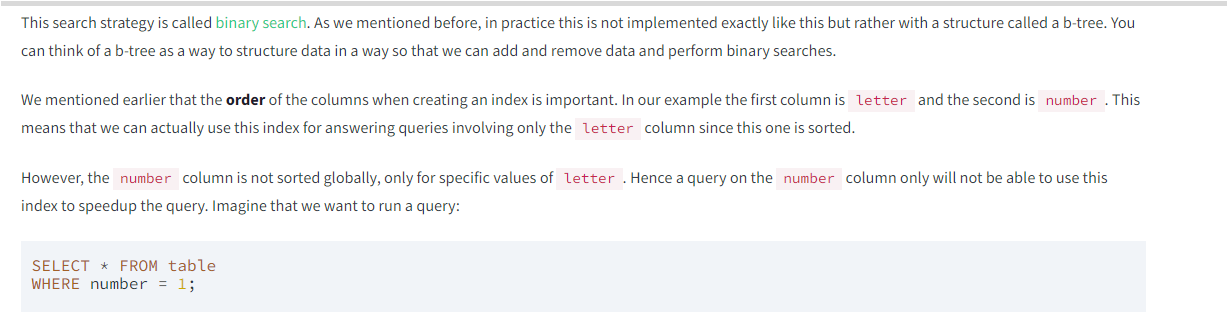

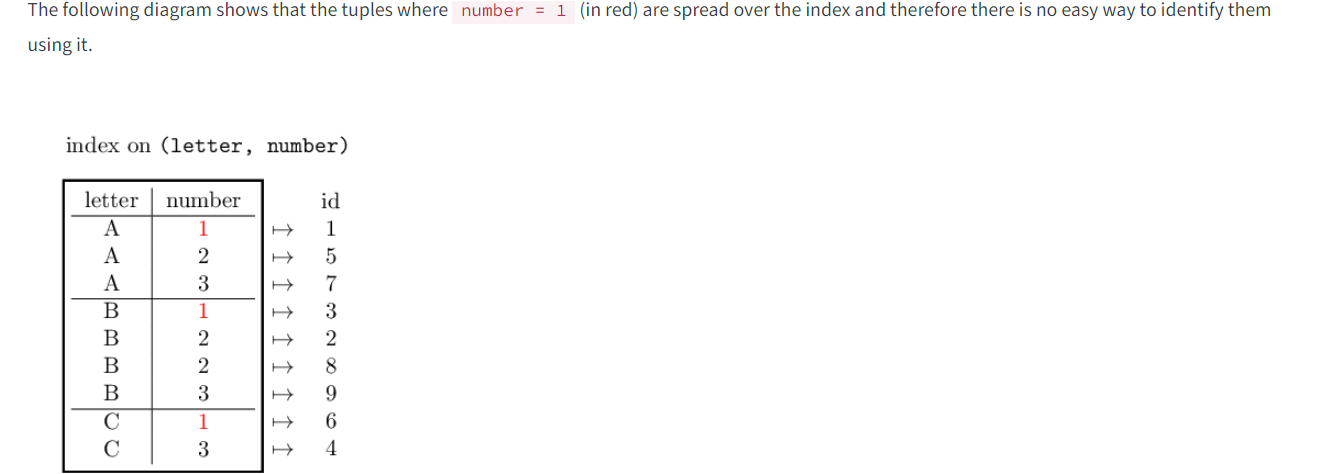

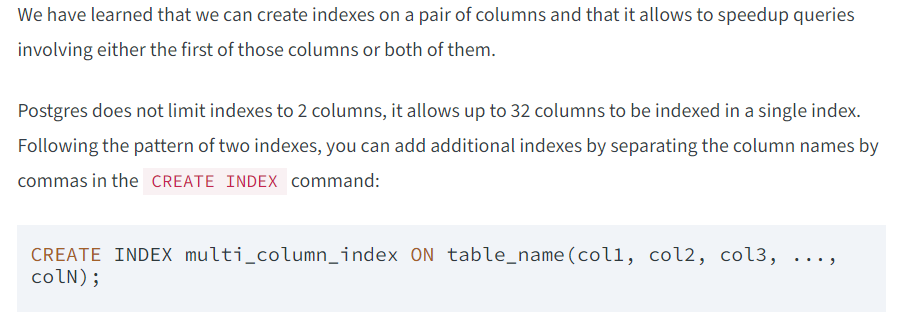

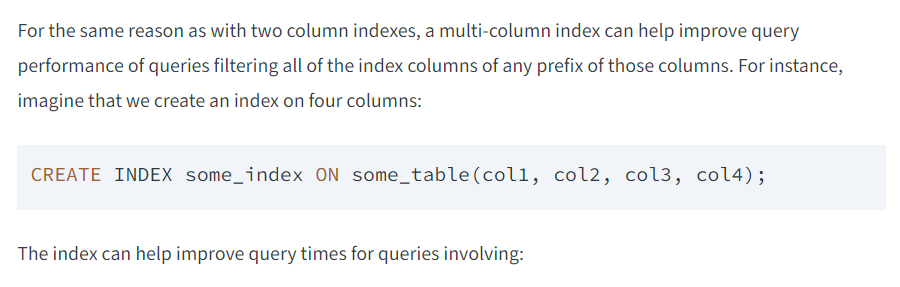

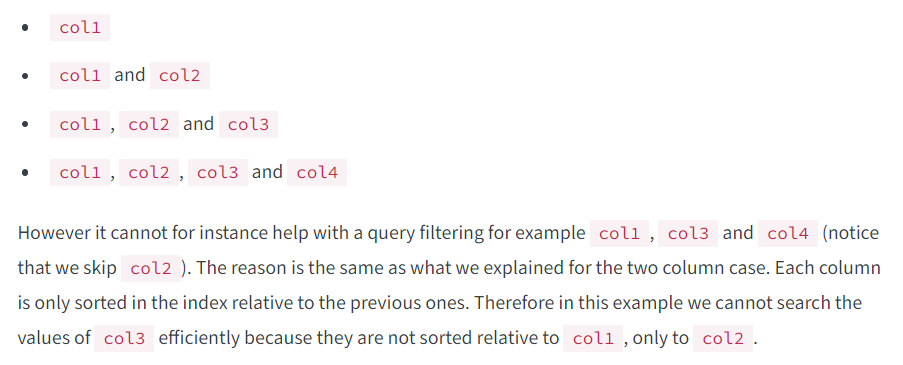

**Task**

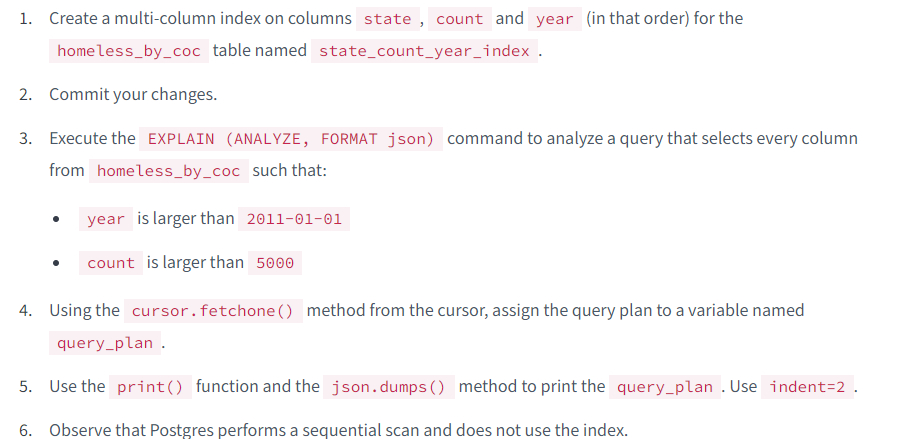

**Answer**

`import psycopg2
import json
conn = psycopg2.connect("dbname=hud user=hud_admin password=hud_pwd")
cur = conn.cursor()`

`cur.execute("CREATE INDEX state_count_year_index ON homeless_by_coc(state, count, year);")
conn.commit()`

`cur.execute("""
    EXPLAIN (ANALYZE, FORMAT json)
    SELECT * FROM homeless_by_coc
    WHERE year > '2011-01-01' AND count > 5000;
""")`

`query_plan = cur.fetchone()
print(json.dumps(query_plan, indent=2))`

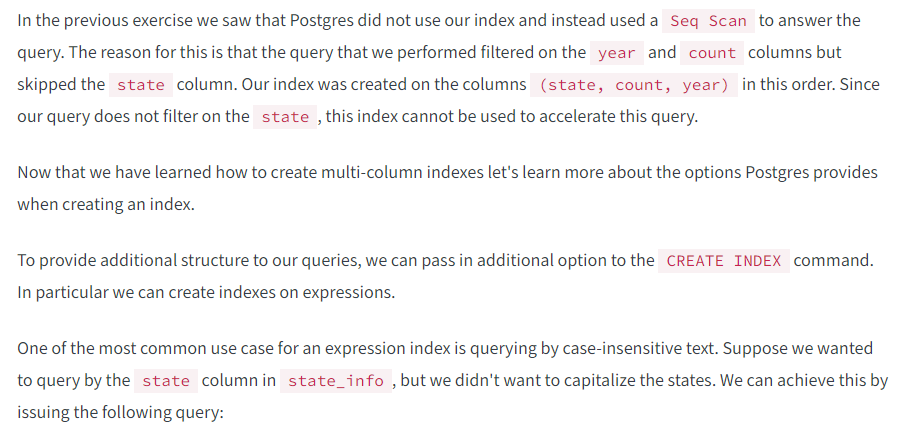

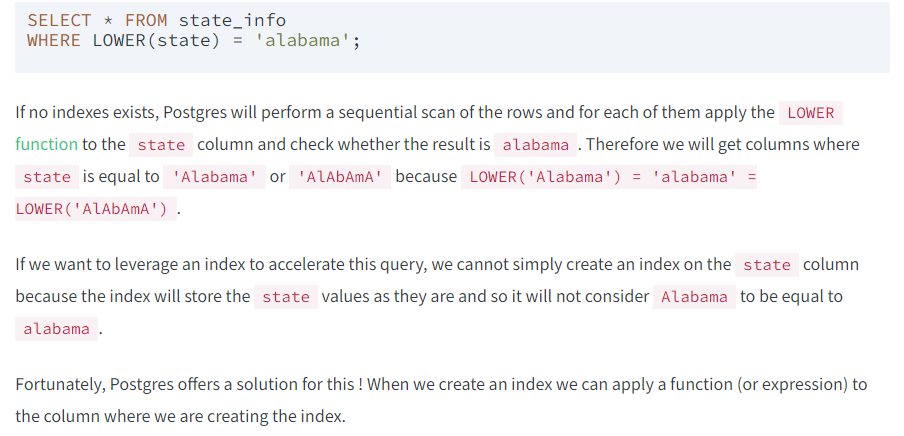

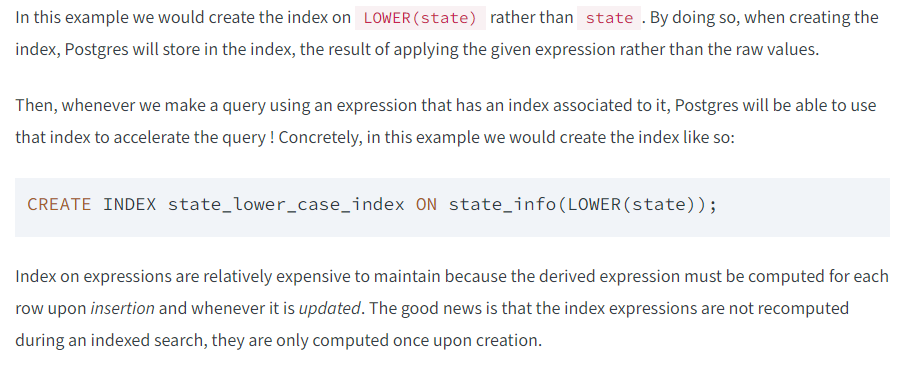

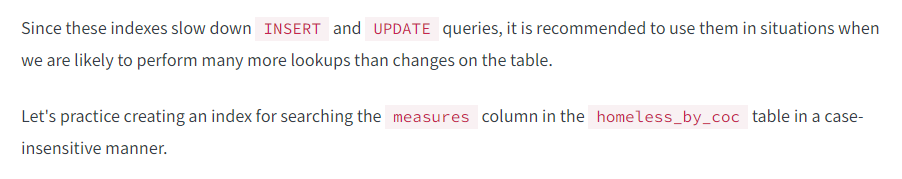

**Task**

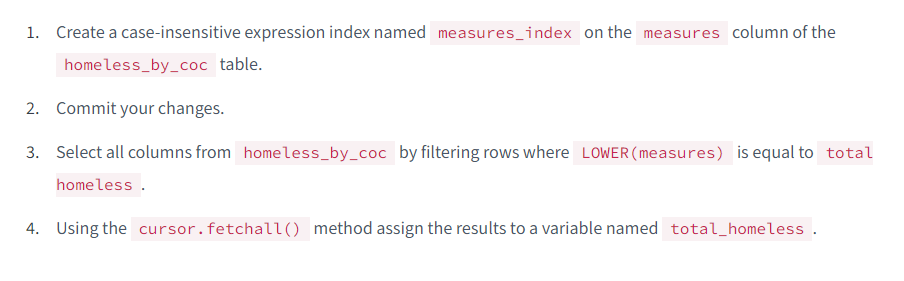

**Answer**

`import psycopg2
conn = psycopg2.connect("dbname=hud user=hud_admin password=hud_pwd")
cur = conn.cursor()`

`cur.execute("CREATE INDEX measures_index ON homeless_by_coc(LOWER(measures));")
conn.commit()`

`cur.execute("""
    SELECT * FROM homeless_by_coc 
    WHERE LOWER(measures) = 'total homeless';
""")`

`total_homeless = cur.fetchall()`

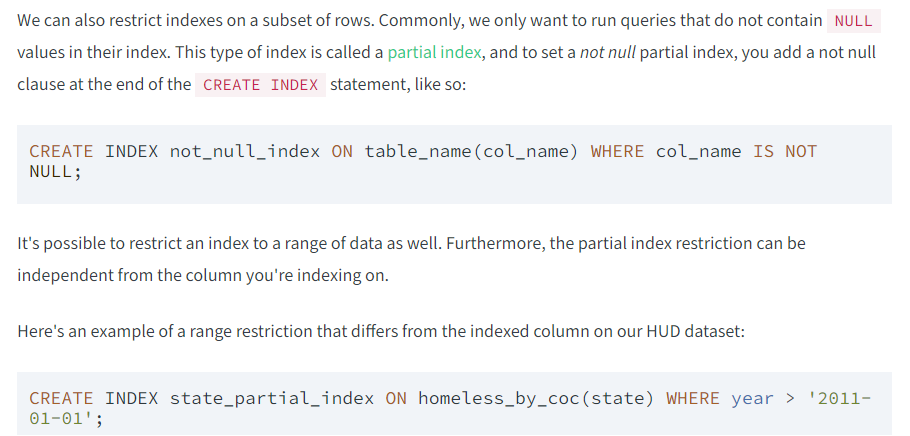

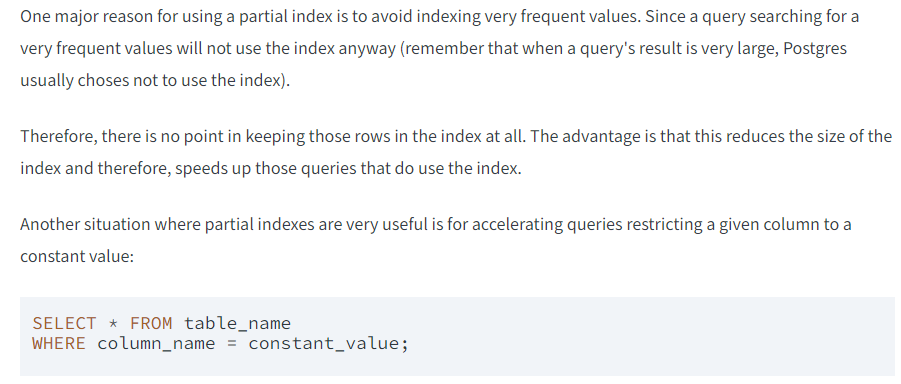

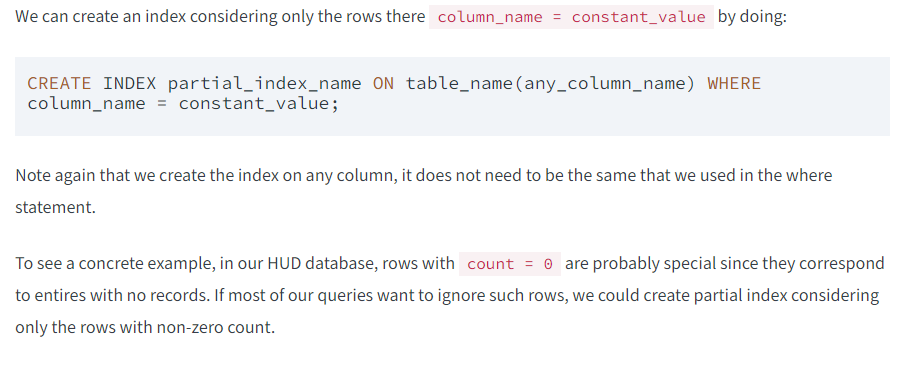

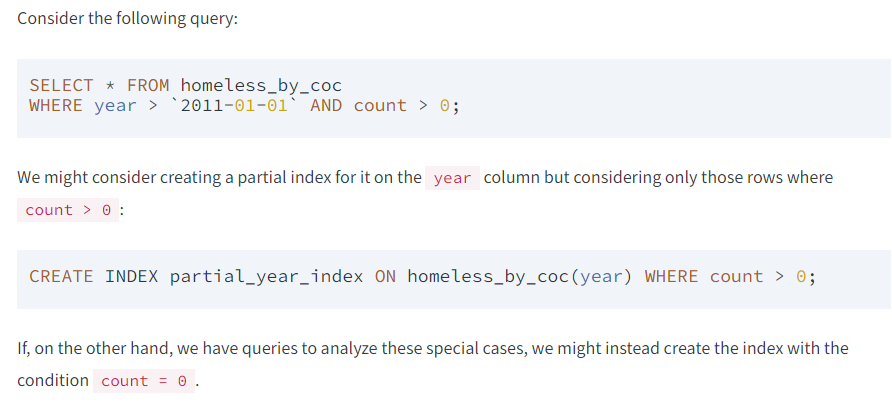

**Task**

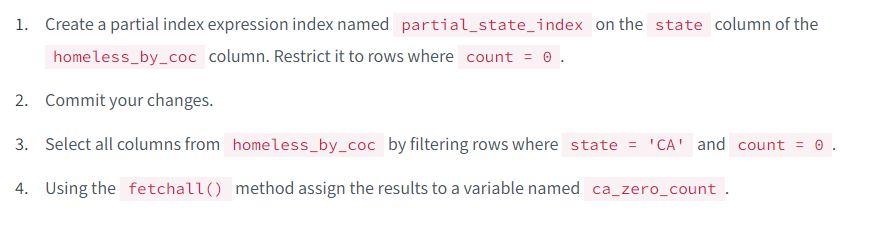

**Answer**

`import psycopg2
conn = psycopg2.connect("dbname=hud user=hud_admin password=hud_pwd")
cur = conn.cursor()
cur.execute("CREATE INDEX partial_state_index ON homeless_by_coc(state) WHERE count = 0;")
conn.commit()`

`cur.execute("""
    SELECT * FROM homeless_by_coc 
    WHERE state  = 'CA' AND count = 0;
""")
ca_zero_count = cur.fetchall()`

Let's take everything we have just learned about indexes, and build our own from scratch. In the following exercise, we will describe a common query the HUD team issues. It will be our job to translate the query into a helpful multi-column index on the `homeless_by_coc table`.

The team uses the following function to issue the query:

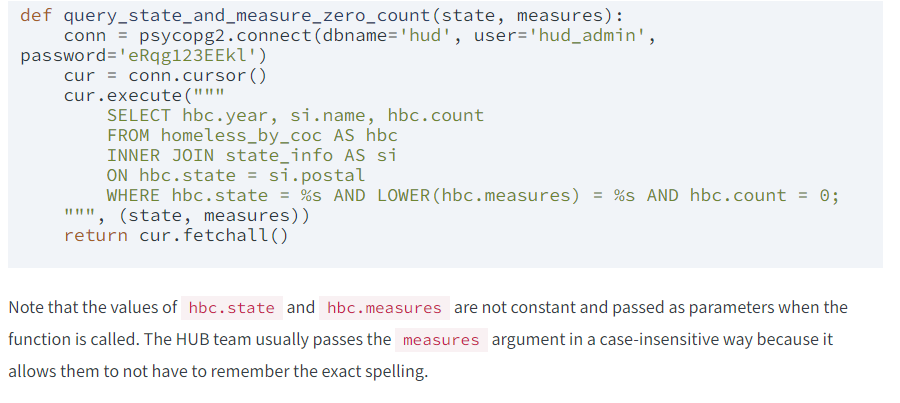

We don't need to use this function in our solution. It is only here for context and show which values vary from one query to another and which ones remain constant.

We are free to design the index as we feel suitable. The goal is to reduce the query time to less than 1 millisecond.

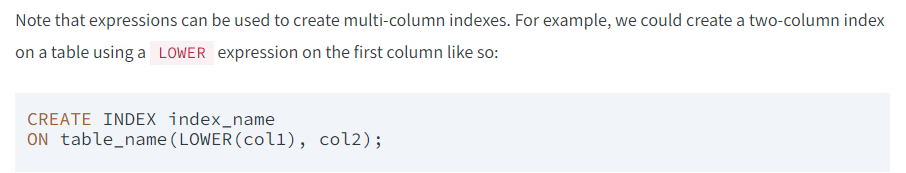

**Task**

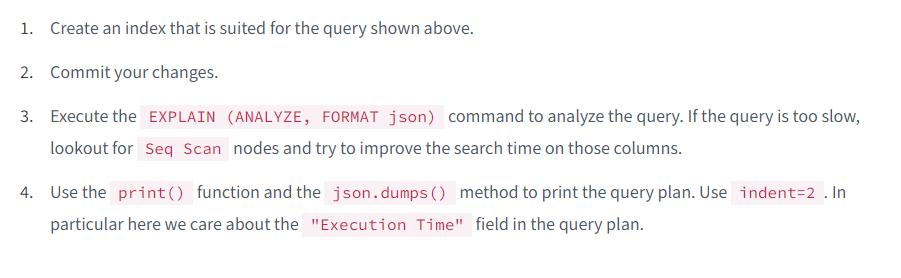

**Answer**

`import psycopg2
conn = psycopg2.connect("dbname=hud user=hud_admin password=hud_pwd")
cur = conn.cursor()`

`cur.execute("""
    CREATE INDEX state_year_measures_idx 
    ON homeless_by_coc(state, LOWER(measures)) 
    WHERE count = 0;
""")
conn.commit()`

`cur.execute("""
    EXPLAIN (ANALYZE, FORMAT json) 
    SELECT hbc.year, si.name, hbc.count
    FROM homeless_by_coc AS hbc
    INNER JOIN state_info AS si
    ON hbc.state = si.postal
    WHERE hbc.state = 'CA' AND hbc.count = 0 AND LOWER(hbc.measures) = 'total homeless';
""")`

`print(json.dumps(cur.fetchone(), indent=2))`

In this file we learned:

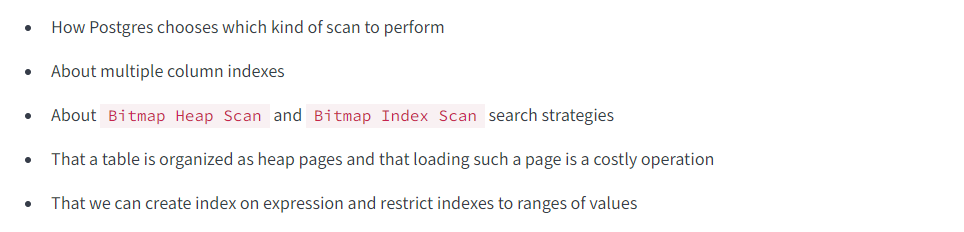

In the next file, we will be using another Postgres tool to speed up queries. We will begin by examining performance degradation that occurs when abusing the `UPDATE` and `DELETE` commands. Then, we will introduce the concept of **database vacuuming** to address these performance issues.